# BM 336546 - HW2: Type 1 Diabetes (T1D)
Daniel sapir & Naama Rivlin

### **Assignment Goal:**
To predict if a patient has T1D, based on binary data from a simple yes/no questionnaire about the patient's medical history, using ML algorithms.

## **Theory Questions**:

**Q1:** To evaluate how well our model performs at T1D classification, we need to have evaluation
metrics that measures of its performances/accuracy. Which evaluation metric is more
important to us: model accuracy or model performance? Give a simple example that
illustrates your claim.

**Q1 Answer:** Accurecy is the fraction of predictions our model got right. Sometimes, accuracy can be misleading, for example when we have very imbalanced data. classification algorithm with an accuracy of 90% could be considered a highly accurate algorithm, but if the data is with a ratio of 90%-10%, even a naive classifier would achieve this accuracy. Therefore, performance is more important to us- evaluation metrics such as F1 score and AUROC are more reliable.  

**Q2:** T1D is often associated with other comorbidities such as a heart attack. You are asked to
design a ML algorithm to predict which patients are going to suffer a heart attack. Relevant
patient features for the algorithm may include blood pressure (BP), body-mass index (BMI),
age (A), level of physical activity (P), and income (I). You should choose between two
classifiers: the first uses only BP and BMI features and the other one uses all of the features
available to you. Explain the pros and cons of each choice.

**Q2 Answer:** \
Using only the **BP and BMI features**:
* Advantage: The required computing power is smaller and it is easier to do data exploration and to clean the data, and the risk for overfitting and noise is smaller
* Disadvantage: We are not guaranteed that these are the two most important features for the purpose of classification (unless it has been tested before with random forest ot PCA for example, like in the next sections). Specifically BP and BMI may be the most important of the 5 features, but even if they are the two most important features, throwing away the other features results in information loss so there may be some harm, even if small, in the quality of the classification

Using **all the features** available:
* Advantage: The model will perform better because it has more information, assuming all the data is clean and reliable and there is no correlation between features that can couse overfitting
* Disadvantage: The required computing power is large, particularly when there are a lot of parameters to tune and when the training set is large. in addition, as mentioned above- to many features can lead to model overfitting

In conclusion, using all the features allows for better performance but is more computationally expensive and can lead to overfitting, whereas using only two features there is a risk of lower performance but less computational power is required and there is less noise.

**Q3:** A histologist wants to use machine learning to tell the difference between pancreas biopsies
that show signs of T1D and those that do not. She has already come up with dozens of
measurements to take, such as color, size, uniformity and cell-count, but she isn’t sure which
model to use. The biopsies are really similar, and it is difficult to distinguish them from the
human eye, or by just looking at the features. Which of the following is better: logistic
regression, linear SVM or nonlinear SVM? Explain your answer.

**Q3 Answer:** Since the biopsies are very similar and it difficult to distinguish them from looking at the features, it is likely that the data is not linearly seperable. For this reason, logistic regression and linear SVM will probably not be good enough, and it will be better for her to use non-linear SVM. Non-linear SVM can use the kernel trick to transform the data into a space where it is linearly seperable and thus achieve better results.  

**Q4:** What are the differences between LR and linear SVM and what is the difference in the
effect/concept of their hyper-parameters tuning?

**Q4 Answer:** 
* LR determines a probability that is a logistic function of a linear combination of the predictors, while SVM aims to fit a hyperplane that separates two classes of data based on the data points at the edge of each class. In other words, LR fits the data points as if they are along a continuous **function**, while SVM fits the data points assuming there are two classes that can be **geometrically** seperated.
* In SVM, a line is considered better than another line if it's **margin is larger**, meaning it is farther from both classes. In LR, a line is better than another line if the the **distribution** defined by it is low at points that belong to class −1 and high at points that belong to class +1  on average (compared to the distribution defined by another line).
* Accordingly, SVM only considers points **near the margin** (support vectors) while LR considers **all the points** in the data set. Therefore, LR is more sensitive to overfitting and to outliers.
* Reagarding model hyperparameters tuning- In LR we tune $\lambda = 1/C$ and in linear SVM we tune **C**, and in both we tune the **penalty** ($L_1$ or $L_2$). C and $\lambda$ adjust how large the penalty will be, and their relationship is inverse. **In linear SVM** C is used to train a "soft margin" SVM. C controls the trade-off of 2 goal- increase the distance of decision boundary to classes, while maximizing the number of points that are correctly classified. **The smaller C is, the smaller the penalty for misclassification is, so we get a large margin at the expense of more misclassifications, and vice versa. The higher C is, the bigger the risk for overfitting is.** **In LR** $\lambda$ is used for regularization, which is controlling the weights magnitude to prevent overfiting. **The smaller $\lambda$ is the bigger the penalty is. Therefore smaller $\lambda$ means bigger risk for overfitting.** for non-linear SVM, there is also $\gamma$ **hyper-parameter**, but for this question we only discuss linear SVM.



## **Coding Assignment:**

There are 565 patients in the database. Some features have missing values. We will start by loading the data from the file HW2_data.csv and do pre-processing.

### **Part 1 - Data loading and pre-processing**

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

file = Path.cwd().joinpath('HW2_data.csv')
T1D_dataset = pd.read_csv(file)

random.seed(10)

We know that the nurse who collected the data said that not all patients answered all the questions, So in some features there are empty values, and we have to decide what to do with them. One option is to through features that have missing values. Another option is delete rows that have missing values. A third option is to fill in the missing cells with random samples from the features. To choose the right option for us, we will first check how many features have empty cells and how many empty cells there are. Than we will check in how many rows there are empty cells, and weather there is a balance between the number of patients with empty values whose diagnosis is "Positive" and those diagnosed as "Negative".

In [2]:
from functions import nancount as ncount
nan_count = ncount(T1D_dataset)
print("The number of nan's in each feature:")
nan_count

The number of nan's in each feature:


{'Age': 0,
 'Gender': 0,
 'Increased Urination': 0,
 'Increased Thirst': 20,
 'Sudden Weight Loss': 9,
 'Weakness': 0,
 'Increased Hunger': 13,
 'Genital Thrush': 14,
 'Visual Blurring': 0,
 'Itching': 11,
 'Irritability': 0,
 'Delayed Healing': 0,
 'Partial Paresis': 0,
 'Muscle Stiffness': 15,
 'Hair Loss': 0,
 'Obesity': 0,
 'Diagnosis': 0,
 'Family History': 0}

We can observe that the largest number of nan's is in the feature 'Increased Thirst' and is equal to 20 (out of 565). This is a relatively small number, so we don't have to through the feature. In most of the features there are no nan's at all.

Before dropping rows with missing values we had:
{'Positive': 343, 'Negative': 222}


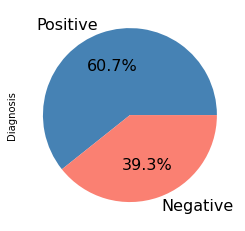

After dropping rows with missing values we have:
{'Positive': 321, 'Negative': 202}


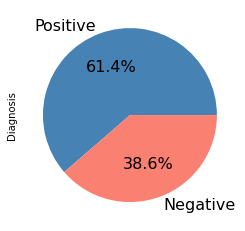

Number of rows with missing values:


42

In [3]:
feat = 'Diagnosis_Positive'
T1D_dummy = pd.get_dummies(T1D_dataset, dummy_na=False, drop_first=True)  # turn all the columns to 0/1 (except 'Age')
T1D_diag = pd.DataFrame(T1D_dummy[feat])

T1D_no_missing = T1D_dataset.copy().dropna()
T1D_no_missing_dummy = pd.get_dummies(T1D_no_missing, dummy_na=False, drop_first=True)
T1D_diag_no_missing = pd.DataFrame(T1D_no_missing_dummy[feat])

diag_cnt = T1D_dataset['Diagnosis'].value_counts().to_dict()
diag_cnt_no_missing = T1D_no_missing['Diagnosis'].value_counts().to_dict()
print("Before dropping rows with missing values we had:")
print(diag_cnt)
T1D_dataset['Diagnosis'].value_counts().plot(kind="pie", labels=['Positive', 'Negative'], colors=['steelblue', 'salmon'], autopct='%1.1f%%', fontsize=16)
plt.show()
print("After dropping rows with missing values we have:")
print(diag_cnt_no_missing)
T1D_no_missing['Diagnosis'].value_counts().plot(kind="pie", labels=['Positive', 'Negative'], colors=['steelblue', 'salmon'], autopct='%1.1f%%', fontsize=16)
plt.show()
print("Number of rows with missing values:")
len(T1D_dataset['Diagnosis'])-len(T1D_no_missing['Diagnosis'])

We see that we lost a similar number of patients from each diagnosis class, and that the fractions of the classes are similar before and after deletion.
We understand from it that by erasing full rows we did not change the balance dramatically.

However, deleting 42 lines out of 565 causes a loss of quite a bit of information, especially considering the fact that there are relatively few patients diagnosed as "Negative", so this information is important. 

For this reason we decided to complete the missing values by random sampling of features, in a way that takes the distribution of the feature into account:

In [4]:
from functions import nan2samp
T1D_clean = nan2samp(T1D_dataset)

### **Part 2 - Train-Test Split**

Our dataset contains mostly binary features. The only non-binary feature is "Age", and it spreads over a much larger range of values than the other variables and therefore may cause bias. For this reason we will do Min-Max scaling only for "Age". After scaling it's range will be between 0 and 1, same as the rest of the features.

In [5]:
# scale "Age"
min_max_scaler = MinMaxScaler()
T1D_clean[['Age']] = min_max_scaler.fit_transform(T1D_clean[['Age']])
# peform train-test split
lbl = np.ravel(T1D_clean['Diagnosis'])
X_train_tmp, X_test_tmp, y_train, y_test = train_test_split(T1D_clean, lbl, test_size=0.2, random_state=10, stratify=lbl)
X_train = X_train_tmp.drop(columns=['Diagnosis'])
X_test = X_test_tmp.drop(columns=['Diagnosis'])

### **Part 3 - Visualization and exploration of the data**

**3.a. An analysis to show that the distribution of the features is similar between test and train:**

We created a table showing distribution between each feature labels in Train and Test Sets:

In [6]:
from functions import dist_table as dist
X_test_dummy = pd.get_dummies(X_test, dummy_na=False, drop_first=True)
X_train_dummy = pd.get_dummies(X_train, dummy_na=False, drop_first=True)
d_table = dist(X_train_dummy, X_test_dummy)
d_table.transpose().round(decimals=2)

,Train %,Test %,Delta %
Family History,48.67,58.41,-9.73
Gender_Male,62.61,68.14,-5.53
Increased Urination_Yes,48.45,47.79,0.66
Increased Thirst_Yes,44.69,44.25,0.44
Sudden Weight Loss_Yes,40.71,43.36,-2.65
Weakness_Yes,55.75,62.83,-7.08
Increased Hunger_Yes,44.69,45.13,-0.44
Genital Thrush_Yes,21.24,28.32,-7.08
Visual Blurring_Yes,44.25,47.79,-3.54
Itching_Yes,48.01,51.33,-3.32


**Q3.a.i:** What issues could an imbalance of features between train and test cause?

**Q3.a.i Answer:** An imbalance of features between the train set and the test set can lead to a model that does not fit the data, since it is not a representative sample of the original dataset. For example, if 50% of patients diagnosed with T1D have family history of the disease, it means that this feature has no meaning to positive classification. If, for example, we get a high percentage of patients who reported family history in the train set and a low percentage in the test set, the model will mark this feature as important for classification. When we run the model on the tets set The feature will get importance when in fact it has no importance, and so we get low performance.

**Q3.a.ii:** How could you solve the issue?

**Q3.a.ii Answer:** We can solve this issue by setting the “stratify” argument to the y (Diagnosis) component of the original dataset. Stratification aims to create a balanced division of the features between the train and the test sets. Looking at the graph below (in the next block), compared to the table above we noticed a more balanced division in features where the labels are the least balanced in the first place. This is because these are the features that have the greatest correlation with classification. Another solution is to penalize our model to avoid overfitting due to imbalance.


**3.b. Plots to show the relationship between feature and label:**

We created a plot showing the frequency of each feature according to Diagnosis:

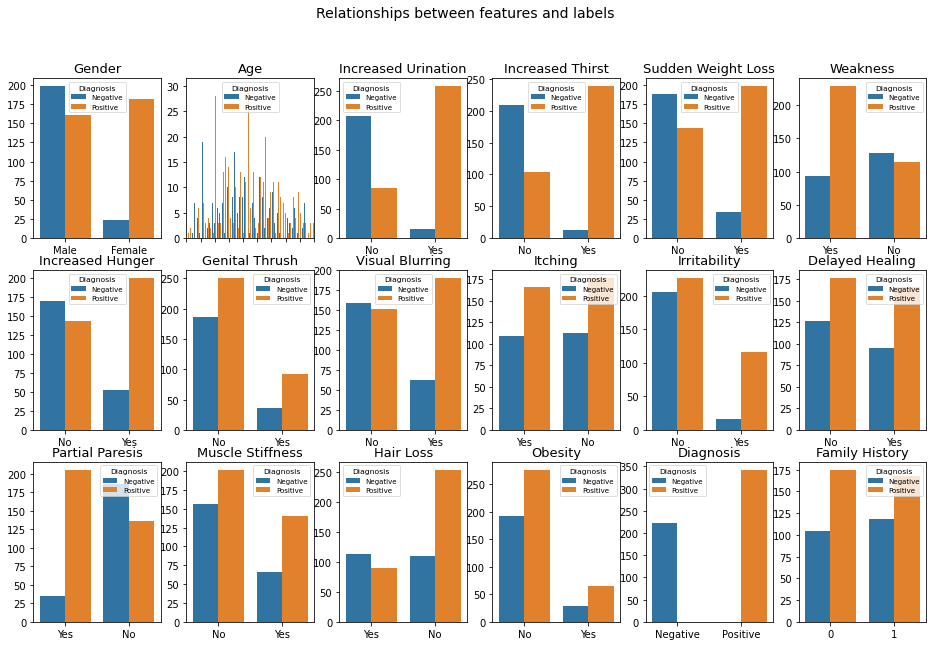

()

In [7]:
from functions import feat_lab_cor as fl_cor
fl_cor(T1D_clean)

The above graph makes it possible to distinguish a number of features that appear to be important for the diagnosis. For example, it can be seen that for "Increased Urination", almost all patients who testified that they had the symptom were diagnosed with the disease. This is a common symptom of T1D and therefore this result makes sense.

**3.c. Additional plots:**

We wanted to take a closer look into the "Age" feature, since it is not binary as the rest of the features:

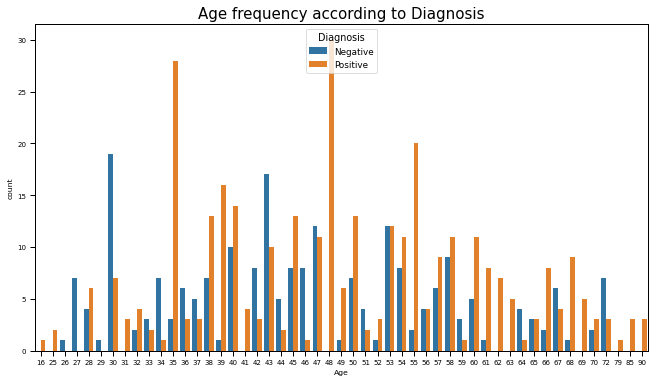

In [8]:
fig, axes = plt.subplots(figsize=(11, 6))
sns.set_context("paper", font_scale=1)
Age_cntplt = sns.countplot(ax=axes, x='Age', hue='Diagnosis', data=T1D_dataset)
Age_cntplt.set_title('Age frequency according to Diagnosis', fontsize=15)
plt.show()

Another plot that will allow us to see the correlation between the features and the diagnosis and between the features themselves is a heatmap of correlations:

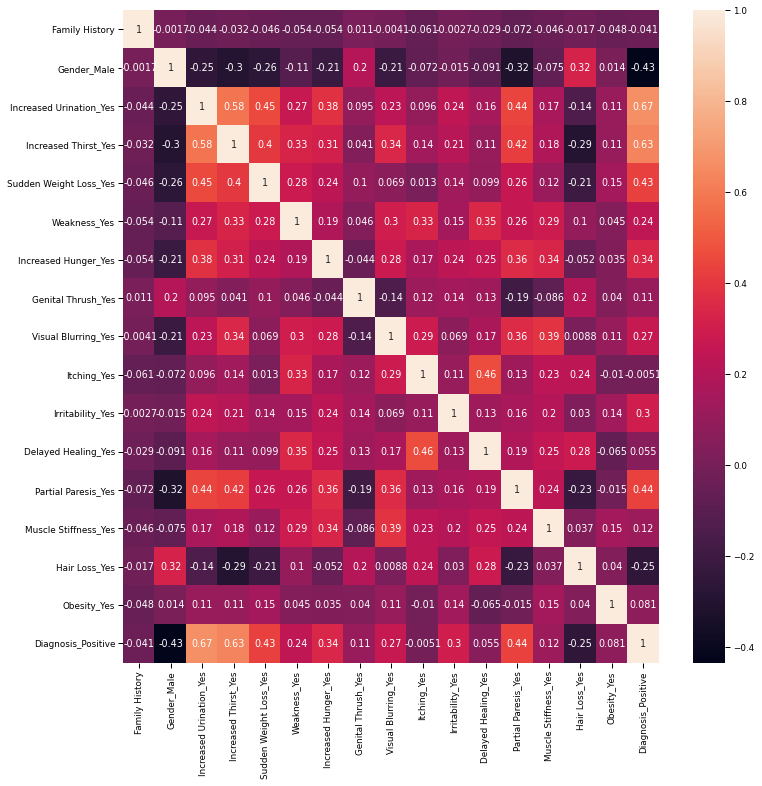

In [9]:
plt.figure(figsize = (12,12))
sns.heatmap(T1D_dummy.iloc[:,1:].corr(), annot = True)
plt.show()

**3.d. Insights:**

**Q3.d.i:** Was there anything unexpected?

**Q3.d.i Answer:** The symptoms indicated by the information source quoted at the beginning of the exercise instructions do appear as important features (some more some less). However, There were some unexpected things- it has been suggested that the source of T1D is genetic but it does not appear that "Family History" is an important feature (the negative and positive division between the two labels is the same). In addition, it is said that the disease tends to appear in childhood but both "Positive" and "Negative" appear to be distributed across the entire age range, with peaks at relatively older ages (35 and 48). Another surprising thing is the imbalance between women and men - most women have been diagnosed as positive, although this (and the age distribution) can be accidental and related to how the data was collected.

**Q3.d.ii:** Are there any features that you feel will be particularly important to your model? Explain why.

**Q3.d.ii Answer:** As noted above, from the graphs showing the relationship between a feature and a label one can identify a number of features that may be important to the model. These are the features for which one of the labels has a significant tendency towards a particular diagnosis. For example, for the **"Increased Urination"** feature most people who reported "Yes" were diagnosed as "Positive" so this is an important feature. Other important features are **"Increased Thirst", "Gender", "Sudden Weight Loss" and "Partial Paresis".** From the correlation heatmap we can tell that **"Increased Urination"** and **"Increased Thirst"** have the highest (positive) correlation with positive diagnosis.

### **Part 4 - Encoding all the data as one hot vectors**

Since we have already done a train-test split in part 2, we will perform the conversion to one hot vectors on the existing train and test sets (although it is possible to first convert to one hot vectors and then do the split).

In [9]:
# Encode X_train and X_test
X_train_ohe_tmp = pd.get_dummies(X_train.iloc[:, 1:], dummy_na=False, drop_first=True)
X_test_ohe_tmp = pd.get_dummies(X_test.iloc[:, 1:], dummy_na=False, drop_first=True)
frames_train = [X_train[["Age"]], X_train_ohe_tmp]
X_train_ohe_forcol = pd.concat(frames_train, axis=1)
X_columns = X_train_ohe_forcol.columns # save the column headers for future use
X_train_ohe = X_train_ohe_forcol.to_numpy()
frames_test = [X_test[["Age"]], X_test_ohe_tmp]
X_test_ohe = pd.concat(frames_test, axis=1).to_numpy()
# Encode y_train and y_test and
ohe = OneHotEncoder(sparse=False)
y_train_ohe = ohe.fit_transform(pd.DataFrame(y_train))
y_test_ohe = ohe.fit_transform(pd.DataFrame(y_test))
y_train_ohe_vec = y_train_ohe[:, 1]  # in the second column 0='Negative' and 1='Positive'
y_test_ohe_vec = y_test_ohe[:, 1]

### **Part 5 - Build and optimize Machine Learning Models**

**5.a.+5.b. Use 5k cross fold validation and tune the models to achieve the highest test AUC:**

**5.a.i.** 
### linear model- Logistic Regression

first, we find the best hyper-parameters, based on highest test AUROC score, with the k-cross fold:

In [10]:
from functions import kcfold
C = np.array([0.01, 0.1, 1, 5, 10])  # regularization parameters
K = 5  # number of folds
penalty = ['l1', 'l2']  # types of penalties
val_dict = kcfold(X_train_ohe, y_train_ohe_vec, C=C, penalty=penalty, K=K)
val_dict_df = pd.DataFrame(val_dict)
idx_roc = val_dict_df['roc_auc'].idxmax()
print("The hyper parameters and AUROC for an optimized model are:")
val_dict[idx_roc]

The hyper parameters and AUROC for an optimized model are:


{'C': 1.0, 'penalty': 'l2', 'roc_auc': 0.9710080701191812}

Now we can use the above parameters to train the model and predict the diagnosis of y_test:

Evaluation metrics for logistic regression after 5K-cross fold validation:
F1 score is: 89.81%
Acc is: 90.27%
AUROC is: 0.967


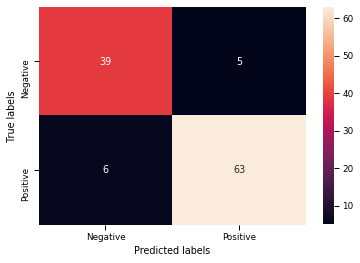

In [11]:
# choosing the best parameters and predict:
from functions import pred_log
c = 1
p = 'l2'
log_reg_best = LogisticRegression(solver='saga', multi_class='ovr', penalty=p, C=c, max_iter=10000, random_state=10)
y_pred_best, w_best = pred_log(log_reg_best, X_train_ohe, y_train_ohe_vec, X_test_ohe)
y_pred_p_best, w_p_best = pred_log(log_reg_best, X_train_ohe, y_train_ohe_vec, X_test_ohe, flag=True)
# evaluation metrics:
print("Evaluation metrics for logistic regression after 5K-cross fold validation:")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_best), average='macro'))) + "%")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_best))) + "%"))
print('AUROC is: {:.3f}'.format(roc_auc_score(y_test_ohe_vec, y_pred_p_best[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_ohe_vec, y_pred_best)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

**5.a.ii.** 
### non-linear model- non-linear SVM

first, we find the best hyper-parameters with the k-cross fold using GridSearchCV:

In [12]:
n_splits = K
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)
svc = SVC(probability=True)
C = np.array([1, 100, 1000])
pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm_nonlin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                        'svm__gamma': ['auto', 'scale']}, scoring=['roc_auc'],
                        cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_nonlin.fit(X_train_ohe, y_train_ohe_vec)
# Choose the best estimator and print them
best_svm_nonlin = svm_nonlin.best_estimator_
print("Non-linear SVM best parameters are:")
svm_nonlin.best_params_

Non-linear SVM best parameters are:


{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}

Now we can use the parameters to train the model and predict the diagnosis of y_test:

evaluation metrics for Non-linear SVM:
F1 score is: 94.46%
Acc is: 94.69%
AUROC is: 0.996


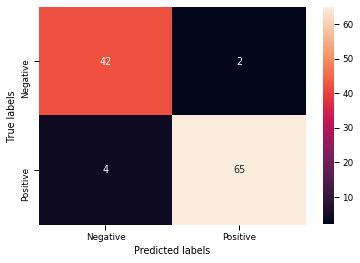

In [13]:
y_pred_test = best_svm_nonlin.predict(X_test_ohe)
y_pred_proba_test = best_svm_nonlin.predict_proba(X_test_ohe)
# evaluation metrics:
print("evaluation metrics for Non-linear SVM:")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_test), average='macro'))) + "%")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_test))) + "%"))
print('AUROC is: {:.3f}'.format(roc_auc_score(y_test_ohe_vec, y_pred_proba_test[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_ohe_vec, y_pred_test)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

**Q5.c:** What performs best on this dataset? Linear or non-linear models?

**Q5.c Answer:**

for the linear model we got:
> - F1 score: 89.81%
> - Acc: 90.27%
> - AUROC: 0.967

For the non-linear model we got:
> - F1 score is: 94.46%
> - Acc is: 94.69%
> - AUROC is: 0.996

That is, in terms of all metrics we found that the nonlinear model works better. Therefore in general we can say that a nonlinear model performs better on this dataset.

### **Part 6 - Feature Selection**

**6.a. Training a Random Forest on the data in order to explore feature importance:**

evaluation metrics for random forest classifier:
Acc is: 97.35%
F1 is: 97.24%
AUROC is 0.998


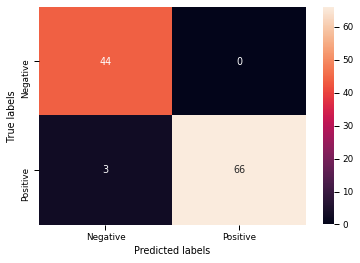

In [14]:
rf_clf = rfc(random_state=10)
rf_clf.fit(X_train_ohe, y_train_ohe_vec)
y_pred = rf_clf.predict(X_test_ohe)
y_pred_p_rf = rf_clf.predict_proba(X_test_ohe)
# evaluation metrics:
print("evaluation metrics for random forest classifier:")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test_ohe_vec, y_pred))) + "%")
print("F1 is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test_ohe_vec, y_pred, average='macro'))) + "%")
print('AUROC is {:.3f}'.format(roc_auc_score(y_test_ohe_vec, y_pred_p_rf[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_ohe_vec, y_pred)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

**6.a.i. finding the 2 most important features according to the random forest:**

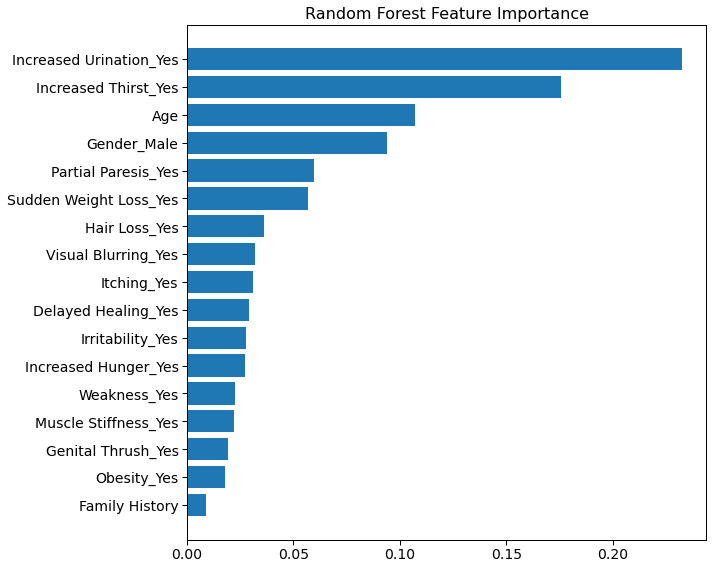

In [15]:
features = rf_clf.feature_importances_
feature_names = np.array(X_columns)
sorted_idx = features.argsort()
y_ticks = np.arange(0, len(features))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, features[sorted_idx])
ax.yaxis.set_major_locator(mticker.FixedLocator(y_ticks))
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title("Random Forest Feature Importance",fontsize=16)
fig.tight_layout()
plt.show()

**Q6.i:** What are the 2 most important features according to the random forest?

**Q6.i Answer:** The two must important features are "Increase Urination" and "Increased Thirst", As can be seen in the figure above.

**Q6.ii:** Does this match up exactly with the feature exploration you did?

**Q6.ii Answer:** indeed. These are exactly the 2 features that seemed most important to us.

### **Part 7 - Data Separability Visualization**

**7.a. Dimensionality reduction on the dataset and into 2D:**

As explained to us, performing dimensionality reduction using PCA on binary data is not recommended. From our time-limited research and search, there are better ways to reduce binary data dimensions, such as logistic PCA and MCA. We left the PCA results here anyway...

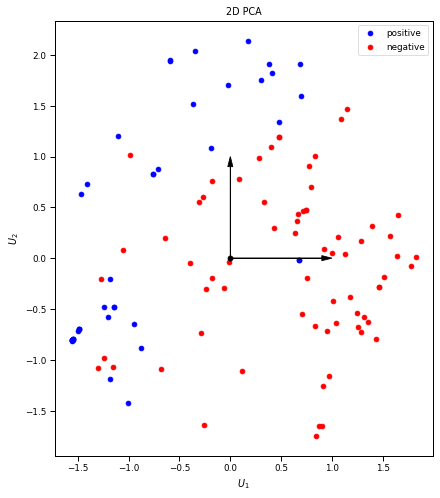

In [29]:
# scaler = StandardScaler()
# X_train_ohe_scaled = scaler.fit_transform(X_train_ohe)
# X_test_ohe_scaled = scaler.transform(X_test_ohe)
n_components = 2
pca = PCA(n_components=n_components, whiten=True)
X_train_ohe_pca = pca.fit_transform(X_train_ohe)
X_test_ohe_pca = pca.transform(X_test_ohe)
# plot the data in a 2d plot
from functions import plt_2d_pca
plt_2d_pca(X_test_ohe_pca,y_test_ohe_vec)

**Q7.b:** How separable is your data when reduced to just two features?

**Q7.b Answer:** The data barely seperable, at least linearly. Some positive values are located deep within the negative group and vice versa, so there is no way to linearly separate the groups without getting relatively many misclassifications. However, the data is not completely mixed and may be more separable in a non-linear way.

**7.c. Training the same models above on the dimensionality-reduced training set**

### Training LR model on the dimensionality-reduced training set:

In [30]:
C = np.array([0.01, 0.1, 1, 5, 10])
val_dict_pca = kcfold(X_train_ohe_pca, y_train_ohe_vec, C=C, penalty=penalty, K=K)
val_dict_pca_df = pd.DataFrame(val_dict_pca)
idx_roc = val_dict_pca_df['roc_auc'].idxmax()
print("The hyper parameters and AUROC for an optimized model are:")
val_dict_pca[idx_roc]

The hyper parameters and AUROC for an optimized model are:


{'C': 5.0, 'penalty': 'l1', 'roc_auc': 0.942604938271605}

Now we can use the best parameters above to train the model and predict the diagnosis of y_test:

Evaluation metrics for logistic regression after 5K-cross fold validation:
F1 score is: 84.36%
Acc is: 84.96%
AUROC is: 0.924


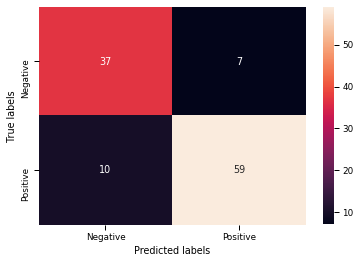

In [31]:
c = 5
p = 'l1'
log_reg_pca = LogisticRegression(solver='saga', multi_class='ovr', penalty=p, C=c, max_iter=10000, random_state=10)
y_pred_pca, w_best = pred_log(log_reg_pca, X_train_ohe_pca, y_train_ohe_vec, X_test_ohe_pca)
y_pred_p_pca, w_p_best = pred_log(log_reg_pca, X_train_ohe_pca, y_train_ohe_vec, X_test_ohe_pca, flag=True)
# evaluation metrics:
print("Evaluation metrics for logistic regression after 5K-cross fold validation:")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_pca), average='macro'))) + "%")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_pca))) + "%"))
print('AUROC is: {:.3f}'.format(roc_auc_score(y_test_ohe_vec, y_pred_p_pca[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_ohe_vec, y_pred_pca)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

### Training a non-linear SVM model on the dimensionality-reduced training set:

In [32]:
C = np.array([1, 100, 1000])
svm_nonlin_pca = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                        'svm__gamma': ['auto', 'scale']}, scoring=['roc_auc'],
                        cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_nonlin_pca.fit(X_train_ohe_pca, y_train_ohe_vec)
# Choose the best estimator and print them
best_svm_nonlin_pca = svm_nonlin_pca.best_estimator_
print("Non-linear SVM best parameters are:")
svm_nonlin_pca.best_params_

Non-linear SVM best parameters are:


{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}

Now we can use the parameters to train the model and predict the diagnosis of y_test:

evaluation metrics for Non-linear SVM:
F1 score is: 87.74%
Acc is: 88.50%
AUROC is: 0.959


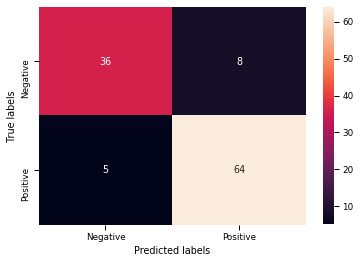

In [33]:
y_pred_svm_pca = svm_nonlin_pca.predict(X_test_ohe_pca)
y_pred_proba_svm_pca = svm_nonlin_pca.predict_proba(X_test_ohe_pca)
# evaluation metrics:
print("evaluation metrics for Non-linear SVM:")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_svm_pca), average='macro'))) + "%")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(pd.DataFrame(y_test_ohe_vec), pd.DataFrame(y_pred_svm_pca))) + "%"))
print('AUROC is: {:.3f}'.format(roc_auc_score(y_test_ohe_vec, y_pred_proba_svm_pca[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_ohe_vec, y_pred_svm_pca)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

**7.d. Training the same models above on the best two features from section 6**

First we create the new df, split and encode as one hot vectors.

In [34]:
# create the new df with 2 features and perform train-test split
Df_2_feat = T1D_clean[["Increased Urination", "Increased Thirst", "Diagnosis"]]
X_train_2_tmp, X_test_2_tmp, y_train_2, y_test_2 = train_test_split(Df_2_feat, lbl, test_size=0.2,
                                                            random_state=10, stratify=lbl)
X_train_2 = X_train_2_tmp.drop(columns=['Diagnosis'])
X_test_2 = X_test_2_tmp.drop(columns=['Diagnosis'])
# Encode X_train and X_test
X_train_2_ohe = pd.get_dummies(X_train_2, dummy_na=False, drop_first=True).to_numpy()
X_test_2_ohe = pd.get_dummies(X_test_2, dummy_na=False, drop_first=True).to_numpy()
# Encode y_train and y_test and
y_train_2_ohe = ohe.fit_transform(pd.DataFrame(y_train_2))
y_test_2_ohe = ohe.fit_transform(pd.DataFrame(y_test_2))
y_train_2_ohe_vec = y_train_2_ohe[:, 1]  # in the second column 0='Negative' and 1='Positive'
y_test_2_ohe_vec = y_test_2_ohe[:, 1]

### Training LR model on the best two features:

In [35]:
# perform 5k-cross fold validation
C = np.array([0.01, 0.1, 1, 5, 10])
val_dict_2 = kcfold(X_train_2_ohe, y_train_2_ohe_vec, C=C, penalty=penalty, K=K)
val_dict_2_df = pd.DataFrame(val_dict_2)
idx_roc = val_dict_2_df['roc_auc'].idxmax()
print("The hyper parameters and AUROC for an optimized model are:")
val_dict_2[idx_roc]

The hyper parameters and AUROC for an optimized model are:


{'C': 0.1, 'penalty': 'l1', 'roc_auc': 0.9053659611992945}

Now we can use the parameters to train the model and predict the diagnosis of y_test:

Evaluation metrics for logistic regression after 5K-cross fold validation:
F1 score is: 83.61%
Acc is: 84.07%
AUROC is: 0.887


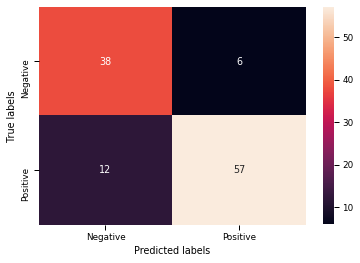

In [36]:
c = 0.1
p = 'l1'
log_reg_2 = LogisticRegression(solver='saga', multi_class='ovr', penalty=p, C=c, max_iter=10000, random_state=10)
y_pred_2, w_2 = pred_log(log_reg_2, X_train_2_ohe, y_train_2_ohe_vec, X_test_2_ohe)
y_pred_p_2, w_p_2 = pred_log(log_reg_2, X_train_2_ohe, y_train_2_ohe_vec, X_test_2_ohe, flag=True)
# evaluation metrics:
print("Evaluation metrics for logistic regression after 5K-cross fold validation:")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(pd.DataFrame(y_test_2_ohe_vec), pd.DataFrame(y_pred_2), average='macro'))) + "%")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(pd.DataFrame(y_test_2_ohe_vec), pd.DataFrame(y_pred_2))) + "%"))
print('AUROC is: {:.3f}'.format(roc_auc_score(y_test_2_ohe_vec, y_pred_p_2[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_2_ohe_vec, y_pred_2)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'],
                           yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

### Training a non-linear SVM model on the best two features:

In [37]:
C = np.array([1, 100, 1000])
svm_nonlin_2 = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                        'svm__gamma': ['auto', 'scale']}, scoring=['roc_auc'],
                            cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_nonlin_2.fit(X_train_2_ohe, y_train_2_ohe_vec)
# Choose the best estimator and print them
best_svm_nonlin_2 = svm_nonlin_2.best_estimator_
print("Non-linear SVM best parameters are:")
svm_nonlin_2.best_params_

Non-linear SVM best parameters are:


{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}

evaluation metrics for Non-linear SVM:
F1 score is: 83.61%
Acc is: 84.07%
AUROC is: 0.883


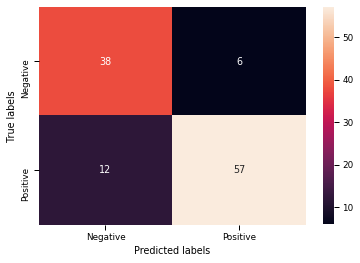

In [38]:
y_pred_svm_2 = svm_nonlin_2.predict(X_test_2_ohe)
y_pred_proba_svm_2 = svm_nonlin_2.predict_proba(X_test_2_ohe)
# evaluation metrics:
print("evaluation metrics for Non-linear SVM:")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(pd.DataFrame(y_test_2_ohe_vec), pd.DataFrame(y_pred_svm_2), average='macro'))) + "%")
print("Acc is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(pd.DataFrame(y_test_2_ohe_vec), pd.DataFrame(y_pred_svm_2))) + "%"))
print('AUROC is: {:.3f}'.format(roc_auc_score(y_test_2_ohe_vec, y_pred_proba_svm_2[:, 1])))
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_2_ohe_vec, y_pred_svm_2)
cnf_heat_map = sns.heatmap(cnf_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
cnf_heat_map.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

**Q7.e:** What performs better? 2 features or the reduced dimensionality?

**Q7.e Answer:** Though we are not sure that the PCA results are reliable, it can be said that reducing the dimensionality gives better results.
Theoretically, the difference between the methods is that dimensionality reduction transforms features into an artificial set but tries to retain important information, while Feature selection is simply selecting features without changing them. In other words, When we use PCA all the features are involved in the reduction, But when we use the best two features, these are the only features that are involved.
PCA may perform better if the most important variables are the ones that happen to have the most variation in them. In such case the PCA contains more information in the 2 components than there is in the 2 selected features. In our case, it is difficult to say whether this is the case because of the binary data issue.

### The End!